In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

d:\Workspace\vinicius\Programs\Miniforge23\envs\diffae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
data = ImageDataset('imgs_interpolate', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

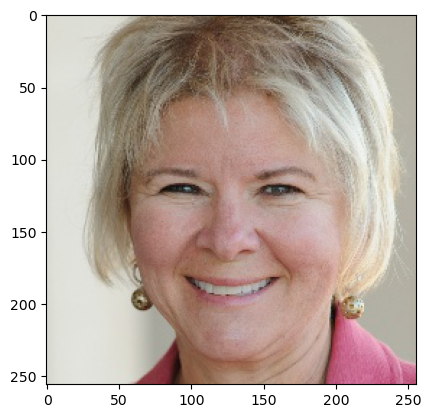

In [5]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

In [6]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


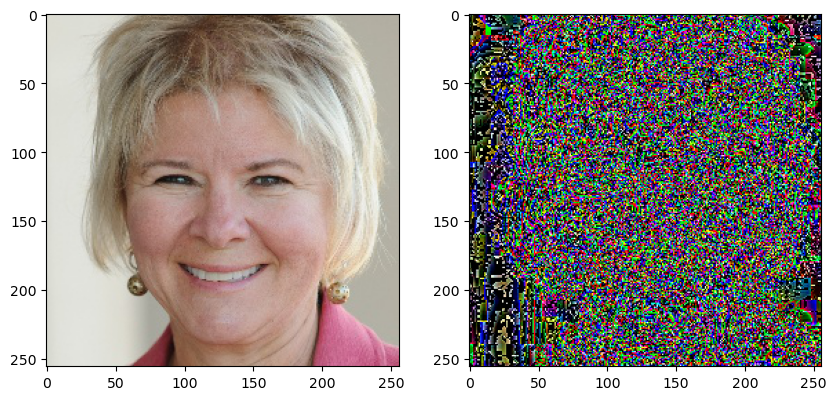

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [8]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=20)

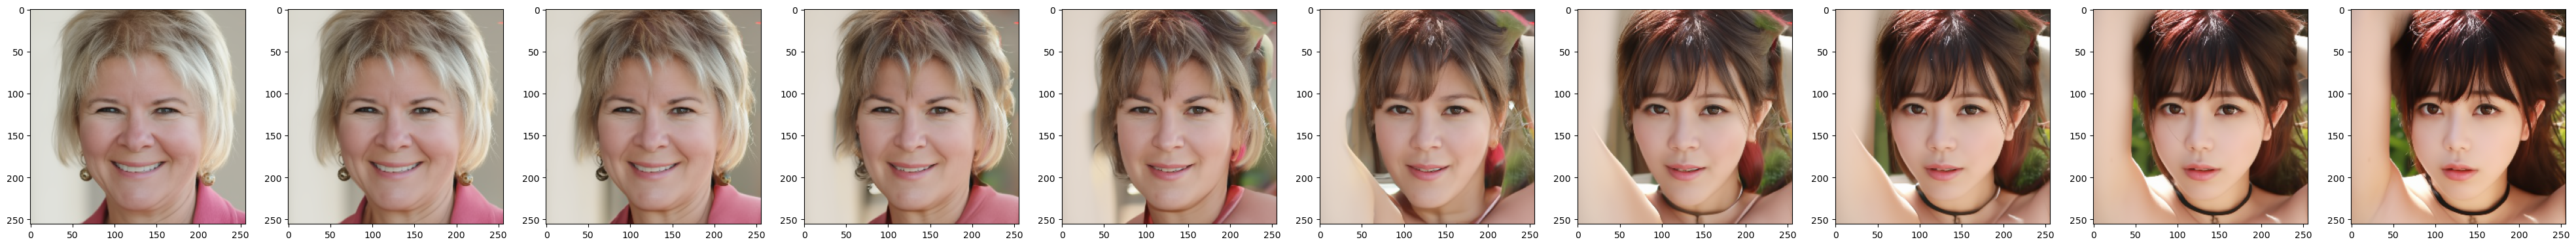

In [9]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')

## Interpolation of images aligned by flow-net

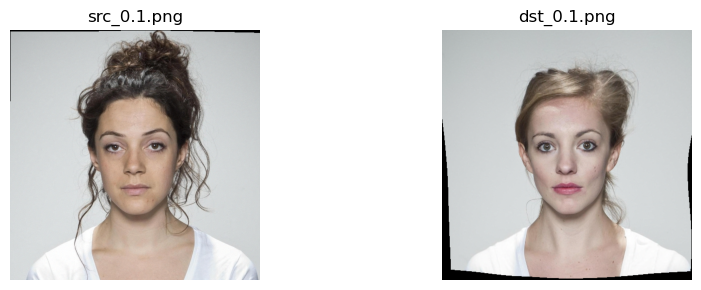

In [10]:
from torchvision.transforms import ToTensor, Normalize, Compose

# 1. Load the Aligned Images
image_folder = 'datasets/frll_001-002_warped'  # Replace this with your folder path
timestamps = np.array([0.1])#np.arange(0.1, 1.0, 0.1)

def load_image_pair(timestamp, image_folder):
    src_img_path = os.path.join(image_folder, f'src_{timestamp:.1f}.png')
    dst_img_path = os.path.join(image_folder, f'dst_{timestamp:.1f}.png')
    
    src_img = Image.open(src_img_path)
    dst_img = Image.open(dst_img_path)
    
    return src_img, dst_img

src_images = []
dst_images = []

# Plotting the image pairs
fig, axes = plt.subplots(len(timestamps), 2, figsize=(10, 3 * len(timestamps)))

for i, timestamp in enumerate(timestamps):
    src_img, dst_img = load_image_pair(timestamp, image_folder)
    
    src_images.append(src_img)
    dst_images.append(dst_img)

    # Handling the single-row case
    if len(timestamps) == 1:
        current_axes = [axes[0], axes[1]]
    else:
        current_axes = axes[i]
    
    current_axes[0].imshow(src_img)
    current_axes[0].set_title(f'Input: src_{timestamp:.1f}.png')
    current_axes[0].axis('off')
    
    current_axes[1].imshow(dst_img)
    current_axes[1].set_title(f'Input: dst_{timestamp:.1f}.png')
    current_axes[1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Lists to store the encodings for each pair
src_semantic_encodings = []
dst_semantic_encodings = []
src_stochastic_encodings = []
dst_stochastic_encodings = []

for i, timestamp in enumerate(timestamps):
    # Convert the PIL images to tensors and normalize them
    src_img_tensor = transform(src_images[i]).unsqueeze(0).to(device)
    dst_img_tensor = transform(dst_images[i]).unsqueeze(0).to(device)
    
    # Encode the Images
    src_cond = model.encode(src_img_tensor)
    dst_cond = model.encode(dst_img_tensor)
    
    src_xT = model.encode_stochastic(src_img_tensor, src_cond, T=250)
    dst_xT = model.encode_stochastic(dst_img_tensor, dst_cond, T=250)
    
    # Append the encodings to the lists
    src_semantic_encodings.append(src_cond[0])
    dst_semantic_encodings.append(dst_cond[0])
    src_stochastic_encodings.append(src_xT[0])
    dst_stochastic_encodings.append(dst_xT[0])


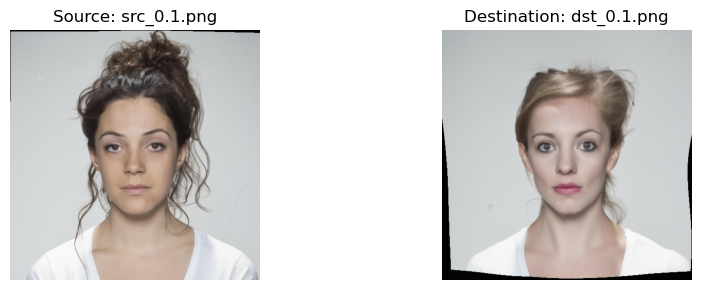

In [18]:
# Lists to store the rendered images for each encoded pair
rendered_src_images = []
rendered_dst_images = []

fig, axes = plt.subplots(len(timestamps), 2, figsize=(10, 3 * len(timestamps)))

for i, timestamp in enumerate(timestamps):
    # Retrieve the stored encodings
    src_cond = src_semantic_encodings[i]
    dst_cond = dst_semantic_encodings[i]
    
    src_xT = src_stochastic_encodings[i]
    dst_xT = dst_stochastic_encodings[i]
    
    # Render the Images from the Encodings
    rendered_src = model.render(src_xT[None], src_cond[None], T=20)[0]
    rendered_dst = model.render(dst_xT[None], dst_cond[None], T=20)[0]
    
    # Append to lists
    rendered_src_images.append(rendered_src)
    rendered_dst_images.append(rendered_dst)
    
    # Handling the single-row case
    if len(timestamps) == 1:
        current_axes = [axes[0], axes[1]]
    else:
        current_axes = axes[i]
    
    # Plot the Original and Rendered Images Side-by-Side
    current_axes[0].imshow(rendered_src.cpu().numpy().transpose(1, 2, 0))
    current_axes[0].set_title(f'Decoded: src_{timestamp:.1f}.png')
    current_axes[0].axis('off')
    
    current_axes[1].imshow(rendered_dst.cpu().numpy().transpose(1, 2, 0))
    current_axes[1].set_title(f'Decoded: dst_{timestamp:.1f}.png')
    current_axes[1].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Lists to store all interpolated images for each pair
all_interpolated_images = []

for i, timestamp in enumerate(timestamps):
    # Retrieve the stored encodings
    src_cond = src_semantic_encodings[i]
    dst_cond = dst_semantic_encodings[i]
    
    src_xT = src_stochastic_encodings[i]
    dst_xT = dst_stochastic_encodings[i]
    
    # Interpolate the Codes
    alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(src_cond.device)
    semantic_intp = src_cond[None] * (1 - alpha[:, None]) + dst_cond[None] * alpha[:, None]

    theta = torch.arccos((src_xT * dst_xT).sum())
    x_shape = src_xT.shape
    stochastic_intp = (torch.sin((1 - alpha[:, None]) * theta) * src_xT.flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * dst_xT.flatten(0, 2)[None]) / torch.sin(theta)
    stochastic_intp = stochastic_intp.view(-1, *x_shape)

    # Render the Interpolated Images
    interpolated_images = model.render(stochastic_intp, semantic_intp, T=20)
    all_interpolated_images.append(interpolated_images)

all_interpolated_images

[tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           ...,
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan]],
 
          [[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           ...,
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan]],
 
          [[nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           ...,
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan],
           [nan, nan, nan,  ..., nan, nan, nan]]],
 
 
         [[[nan, nan, nan,  ..., nan, nan, nan],
         